In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import RandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

sys.path.append(os.path.abspath(os.path.join('..', '..\\models')))
from NODE import NODEClassifier
from SAINT import SAINTClassifier
from TabTransformers import TabTrClassifier

# Data Loading

In [2]:
df_train = pd.read_csv('..\\..\\datasets\\predict-bank-churn.csv')

# EDA

In [3]:
df_train.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [4]:
# Dataset Dimension
df_train.shape

(165034, 14)

In [5]:
# Missing Values Check
df_train.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
# Descriptive statistics of numerical features
df_train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
# Determine the continous numerical features
num_cont_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']

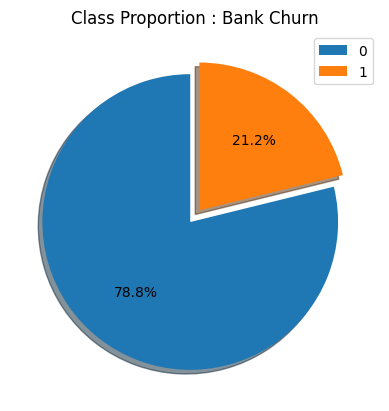

In [34]:
# Count frequency each class
category_counts = df_train['Exited'].value_counts()
size = df_train['Exited'].value_counts()

# Create Bar Chart
plt.pie(size, startangle=90, shadow=True, explode=[0.05]*len(size), autopct='%.1f%%')
plt.legend(labels=category_counts.index)
plt.title('Class Proportion : Bank Churn')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

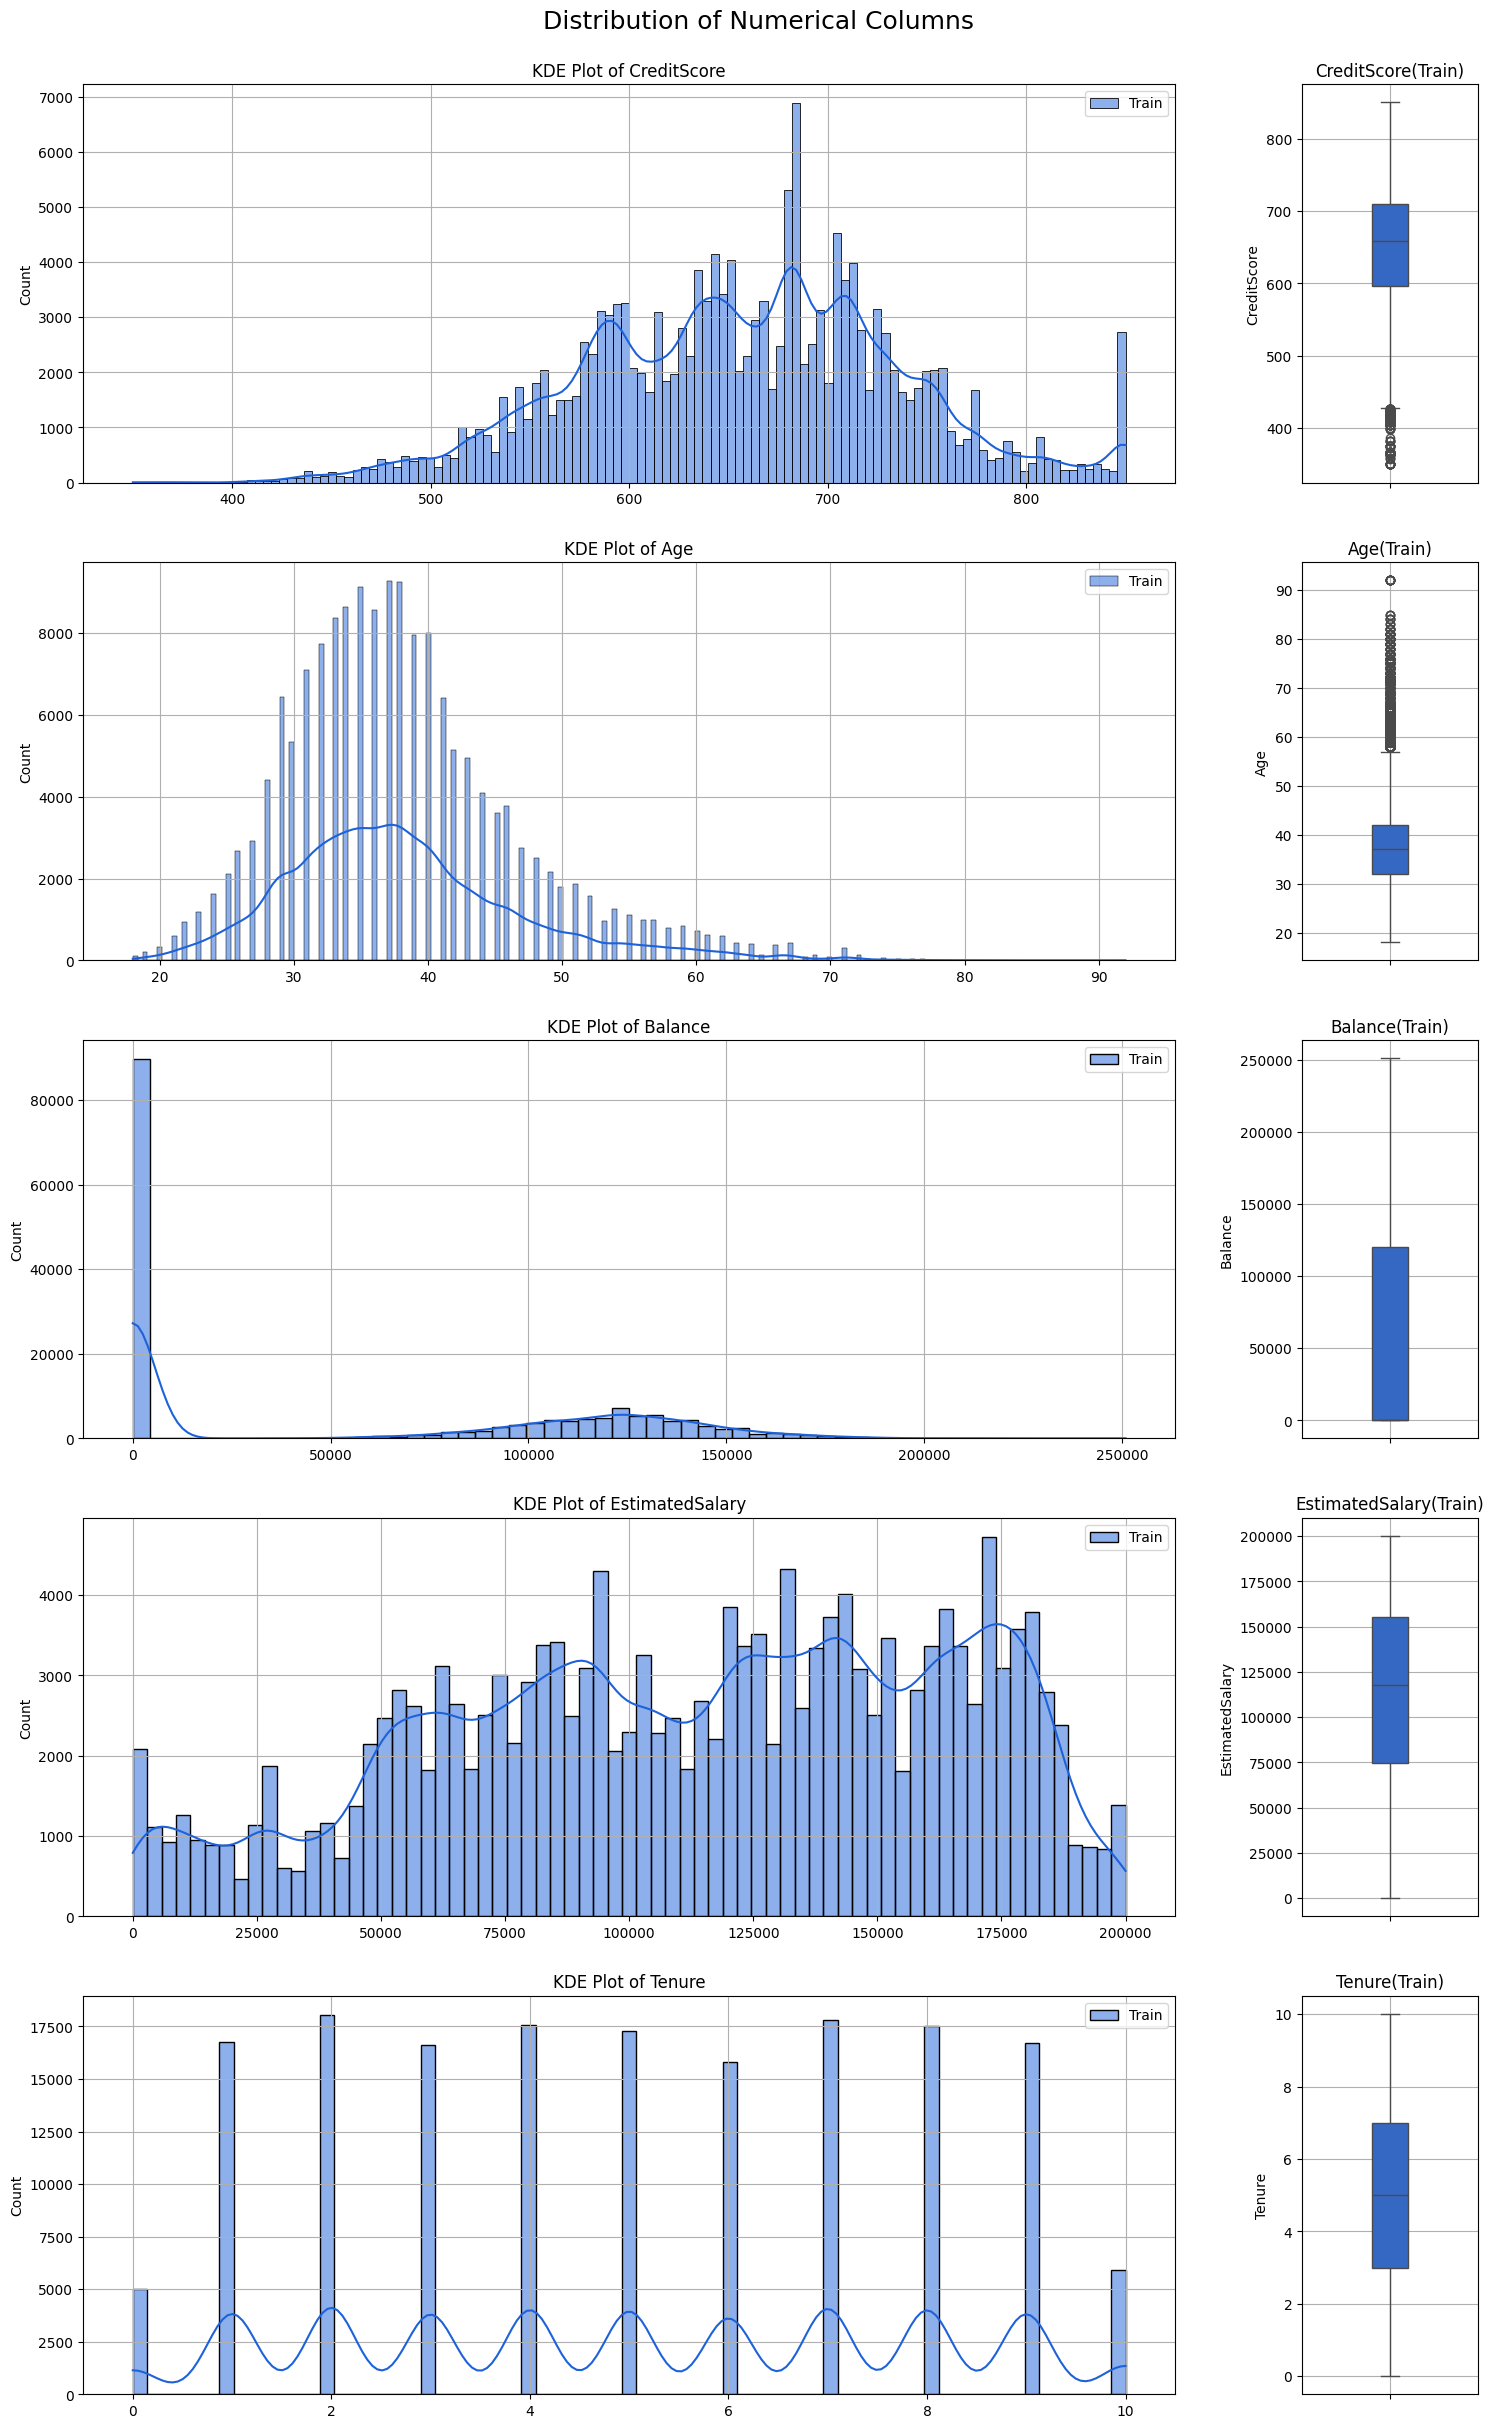

In [9]:
# Distribution Analysis - Numeric Features
fig, axes = plt.subplots(5, 2, figsize=(18, 30), gridspec_kw = {'width_ratios': [0.93, 0.15]})

color_train = '#1D62DA'

for i, col in enumerate(num_cont_features):
    sns.histplot(data=df_train[col], ax=axes[i,0], label='Train', color=color_train, kde=True)
    axes[i,0].grid('True')
    axes[i,0].set_title('KDE Plot of '+col)
    axes[i,0].set_xlabel('')
    axes[i,0].legend()
    
    sns.boxplot(y=col, data=df_train, ax=axes[i,1], color=color_train, width=0.2)
    axes[i,1].grid('True')
    axes[i,1].set_xlabel('')
    axes[i,1].set_title(col+'(Train)')
    
plt.suptitle('Distribution of Numerical Columns', fontsize=18, y=0.905)
plt.tight_layout    
plt.show

# Preprocessing

In [10]:
df_train.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [11]:
def preprocessing(df):
    df_processed = df_train.copy()

    # drop non-informative column
    df_processed.drop(columns=['id', 'CustomerId', 'Surname'], inplace=True)
    
    # encode geography & gender
    df_processed = pd.get_dummies(df_processed, columns=['Geography', 'Gender'])

    # split data into feature & target
    X = df_processed.drop(columns='Exited')
    y = df_processed['Exited']
    print(df_processed.shape)

    # split data into train & test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # change the scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # change to array
    X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
    y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

    return X_train, X_test, y_train, y_test


In [12]:
X_train, X_test, y_train, y_test = preprocessing(df_train)

(165034, 14)


In [13]:
# Determine the input and output dimensions
input_dim = df_train.drop(columns='Exited').shape[1]
output_dim = df_train['Exited'].nunique()

# Modelling

In [14]:
# Convert df to tensor
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [15]:
# Dataframe for evaluation result each model
eval_columns = ['Model', 'Accuracy', 'F1']
eval_results = pd.DataFrame(columns=eval_columns)
eval_results

,Model,Accuracy,F1,ROC AUC


## Train Eval Function

In [16]:
def train_eval(model, model_name, X_train, X_test, y_train, y_test):
    # Define start time recording
    start_time = time.time()
    if not isinstance(model, TabNetClassifier):
        model.fit(X_train, y_train)
    else : 
        model.fit(X_train=X_train, 
                y_train=y_train, 
                eval_set=[(X_test, y_test)],
                eval_metric=['accuracy'],
                max_epochs=100, 
                patience=10,
                batch_size=256,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False)
    # Predict
    y_pred = model.predict(X_test)
    # Eval
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1: {f1:.4f}")
    # Define end time recording
    end_time = time.time()
    # Calculate the execution time
    execution_time = end_time - start_time

    result = pd.DataFrame([{'Model':model_name, 'Accuracy':accuracy, 'F1':f1, 'Execution Time':execution_time}])

    return result

## Deep Learning

### NODE : Neural Oblivious Decision Ensemble

In [17]:
# Instantiate NODE Model
NODE_model = NODEClassifier(
    input_dim, 
    output_dim, 
    num_trees=56, 
    tree_depth=6, 
    hidden_dim=128, 
    batch_size=256, 
    num_epochs=100, 
    learning_rate=0.001
    )

In [18]:
# Begin the training & eval process
result = train_eval(NODE_model, "NODE Classifier", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Epoch [10/100], Loss: 0.3220, Accuracy: 0.86
Epoch [20/100], Loss: 0.3173, Accuracy: 0.87
Epoch [30/100], Loss: 0.3124, Accuracy: 0.87
Epoch [40/100], Loss: 0.3057, Accuracy: 0.87
Epoch [50/100], Loss: 0.2951, Accuracy: 0.88
Epoch [60/100], Loss: 0.2848, Accuracy: 0.88
Epoch [70/100], Loss: 0.2728, Accuracy: 0.89
Epoch [80/100], Loss: 0.2610, Accuracy: 0.90
Epoch [90/100], Loss: 0.2501, Accuracy: 0.90
Epoch [100/100], Loss: 0.2395, Accuracy: 0.90
Training process has finished
Accuracy: 0.8448
F1: 0.8400


C:\Users\fadhil\AppData\Local\Temp\ipykernel_31040\2910927492.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_results = pd.concat([result, eval_results], ignore_index=True)


#### Optuna

In [19]:
# def NODE_objectives(trial):
#     num_trees = trial.suggest_int('num_trees', 10, 100)
#     tree_depth = trial.suggest_int('tree_depth', 5, 10)

#     NODE_model = NODE(
#         input_dim = X_dim,
#         output_dim = y_dim,
#         num_trees = num_trees,
#         tree_depth = tree_depth,
#         hidden_dim = 128
#     )
    
#     avg_auc_roc = train_model(NODE_model, X_train_t, X_test_t, y_train_t, y_test_t)

#     return avg_auc_roc

In [20]:
# study = optuna.create_study(direction='maximize')
# study.optimize(NODE_objectives, n_trials=50)
# trial = study.best_trial

# print('Value: ', trial.value)
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

### Tab-Transformer

In [21]:
# Define Tab-Transfomer Model
TabTR_model = TabTrClassifier(
    input_dim=input_dim,
    output_dim=output_dim,
    embed_size=32,
    num_heads=4,
    forward_expansion=128,
    dropout=0.1,
    batch_size=256, 
    num_epochs=100, 
    learning_rate=0.001
)

In [22]:
result = train_eval(TabTR_model, "Tab-Transformer", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Epoch [10/100], Loss: 0.3256, Accuracy: 0.86
Epoch [20/100], Loss: 0.3239, Accuracy: 0.86
Epoch [30/100], Loss: 0.3226, Accuracy: 0.86
Epoch [40/100], Loss: 0.3223, Accuracy: 0.86
Epoch [50/100], Loss: 0.3220, Accuracy: 0.87
Epoch [60/100], Loss: 0.3217, Accuracy: 0.86
Epoch [70/100], Loss: 0.3213, Accuracy: 0.87
Epoch [80/100], Loss: 0.3215, Accuracy: 0.87
Epoch [90/100], Loss: 0.3208, Accuracy: 0.87
Epoch [100/100], Loss: 0.3203, Accuracy: 0.86
Training process has finished
Accuracy: 0.8652
F1: 0.8560


### TabNet

In [23]:
# Define TabNet Model
TabNet_model = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         scheduler_params=dict(step_size=10, gamma=0.9),
                         mask_type='sparsemax')

result = train_eval(TabNet_model, "Tabnet", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.37821 | val_0_accuracy: 0.85109 |  0:00:15s
epoch 1  | loss: 0.34033 | val_0_accuracy: 0.86233 |  0:00:30s
epoch 2  | loss: 0.33363 | val_0_accuracy: 0.86251 |  0:00:46s
epoch 3  | loss: 0.33354 | val_0_accuracy: 0.86079 |  0:01:01s
epoch 4  | loss: 0.33314 | val_0_accuracy: 0.86348 |  0:01:16s
epoch 5  | loss: 0.33248 | val_0_accuracy: 0.86221 |  0:01:31s
epoch 6  | loss: 0.33999 | val_0_accuracy: 0.85476 |  0:01:46s
epoch 7  | loss: 0.33482 | val_0_accuracy: 0.84846 |  0:02:02s
epoch 8  | loss: 0.34372 | val_0_accuracy: 0.85388 |  0:02:18s
epoch 9  | loss: 0.33783 | val_0_accuracy: 0.86309 |  0:02:33s
epoch 10 | loss: 0.33656 | val_0_accuracy: 0.85636 |  0:02:49s
epoch 11 | loss: 0.33552 | val_0_accuracy: 0.86436 |  0:03:05s
epoch 12 | loss: 0.33429 | val_0_accuracy: 0.8563  |  0:03:20s
epoch 13 | loss: 0.34512 | val_0_accuracy: 0.85373 |  0:03:36s
epoch 14 | loss: 0.35276 | val_0_accuracy: 0.85152 |  0:03:52s
epoch 15 | loss: 0.35221 | val_0_accuracy: 0.85239 |  0

c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.8644
F1: 0.8571


### SAINT : Self Attention & Intersample Attention

In [24]:
SAINT_model = SAINTClassifier(
    input_dim = input_dim,
    output_dim = output_dim,
    attn_dim = 16,
    num_heads = 2,
    dropout=0.1,
    num_layers = 3,
    hidden_dim = 64,
    size_of_batch=256, 
    num_epochs=100, 
    learning_rate=0.001
)

In [25]:
result = train_eval(SAINT_model, "SAINT", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Epoch [10/100], Loss: 0.3659, Accuracy: 0.85
Epoch [20/100], Loss: 0.3637, Accuracy: 0.85
Epoch [30/100], Loss: 0.3636, Accuracy: 0.85
Epoch [40/100], Loss: 0.3617, Accuracy: 0.85
Epoch [50/100], Loss: 0.3616, Accuracy: 0.84
Epoch [60/100], Loss: 0.3626, Accuracy: 0.85
Epoch [70/100], Loss: 0.3607, Accuracy: 0.85
Epoch [80/100], Loss: 0.3612, Accuracy: 0.85
Epoch [90/100], Loss: 0.3602, Accuracy: 0.85
Epoch [100/100], Loss: 0.3596, Accuracy: 0.85
Training process has finished
Accuracy: 0.8623
F1: 0.8502


## Machine Learning

### Random Forest

In [26]:
# Define Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Train & Eval with function
result = train_eval(rf_model, "Random Forest", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.8577
F1: 0.8502


### LightGBM

In [27]:
# Define LightGBM Model
lgbm_model = LGBMClassifier(random_state=42)

# Train & Eval with function
result = train_eval(lgbm_model, "LightGBM", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
Accuracy: 0.8684
F1: 0.8614


### XGBoost

In [28]:
# Define XGBoost Model
xgb_model = XGBClassifier(random_state=42)

# Train & Eval with function
result = train_eval(xgb_model, "XGBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.8662
F1: 0.8595


### CatBoost

In [29]:
# Define CatBoost Model
cb_model = CatBoostClassifier(random_state=42)

# Train & Eval with function
result = train_eval(cb_model, "CatBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Learning rate set to 0.082881
0:	learn: 0.6180166	total: 133ms	remaining: 2m 12s
1:	learn: 0.5603249	total: 145ms	remaining: 1m 12s
2:	learn: 0.5124327	total: 157ms	remaining: 52.2s
3:	learn: 0.4767282	total: 168ms	remaining: 41.8s
4:	learn: 0.4484816	total: 179ms	remaining: 35.6s
5:	learn: 0.4261401	total: 191ms	remaining: 31.6s
6:	learn: 0.4087262	total: 201ms	remaining: 28.5s
7:	learn: 0.3946403	total: 213ms	remaining: 26.4s
8:	learn: 0.3825969	total: 224ms	remaining: 24.7s
9:	learn: 0.3730406	total: 234ms	remaining: 23.2s
10:	learn: 0.3655105	total: 245ms	remaining: 22.1s
11:	learn: 0.3594527	total: 256ms	remaining: 21.1s
12:	learn: 0.3544573	total: 269ms	remaining: 20.4s
13:	learn: 0.3498747	total: 283ms	remaining: 19.9s
14:	learn: 0.3462292	total: 297ms	remaining: 19.5s
15:	learn: 0.3430676	total: 311ms	remaining: 19.1s
16:	learn: 0.3406508	total: 324ms	remaining: 18.7s
17:	learn: 0.3380578	total: 337ms	remaining: 18.4s
18:	learn: 0.3360874	total: 350ms	remaining: 18s
19:	learn: 

# Evaluation

In [33]:
eval_results

,Model,Accuracy,F1,Execution Time
0,CatBoost,0.867846,0.860211,10.689055
1,XGBoost,0.866210,0.859459,2.394554
2,LightGBM,0.868422,0.861445,0.737587
3,Random Forest,0.857727,0.850156,14.698200
4,SAINT,0.862302,0.850202,1004.899187
5,Tabnet,0.864362,0.857119,352.235250
6,Tab-Transformer,0.865210,0.855986,581.964573
7,NODE Classifier,0.844790,0.839951,888.759308


In [31]:
# eval_results.to_excel('BankChurn_Eval_Results.xlsx', index=False)